In [ ]:
from google.colab import drive #imports drive moudle from colab to mount the google drive and access the file placed by the user.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

drive.mount('/content/gdrive')
#training_data = pd.read_csv('/kaggle/input/fraudulent-transactions-prediction/Fraud.csv')

#Load the fraud dataset:
training_data = pd.read_csv("gdrive/MyDrive/transactions/Fraud.csv")

#Feature Engineering: new features created for the model overall.
training_data['balanceOrigDiff'] = training_data['oldbalanceOrg'] - training_data['newbalanceOrig']
training_data['balanceDestDiff'] = training_data['oldbalanceDest'] - training_data['newbalanceDest']

#training_data['isPayment'] = (training_data['type'] == 'PAYMENT').astype(int)
#training_data['isTransfer'] = (training_data['type'] == 'TRANSFER').astype(int)
#training_data['isCashOut'] = (training_data['type'] == 'CASH_OUT').astype(int)
#training_data['isCashIn'] = (training_data['type'] == 'CASH_IN').astype(int)
#training_data['isDebit'] = (training_data['type'] == 'DEBIT').astype(int)

# Flag transactions occurring during off-peak hours (12 AM to 5 AM)
training_data['isOffPeak'] = ((training_data['step'] % 24).isin([0, 1, 2, 3, 4, 5])).astype(int)


# Print the first few rows to understand the structure
#print("Dataset Preview:\n", training_data.head())
# Print the column names to check what data is available
#print("Columns in Dataset:\n", training_data.columns)

# one-hot encoding
# drop these two because it would require 420. TiB for an array
# with shape (6362620, 9075674)
training_data = training_data.drop(
    ['nameOrig', 'nameDest'], axis=1)
# get categorical columns from dataframe
categorical_columns = training_data.select_dtypes(include=['object']).columns.tolist()
#print(categorical_columns)
encoder = OneHotEncoder(sparse_output=False)
# one-hot encode categorical columns
one_hot_encoded = encoder.fit_transform(training_data['type'].values.reshape(-1, 1))
# create dataframe of one-hot encoded categorical columns
one_hot_data = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_columns))
# combind non-categorical data with one-hot encoded categorical data
data_encoded = pd.concat([training_data, one_hot_data], axis = 1)
# remove redundent categorical columns
data_encoded = data_encoded.drop(categorical_columns, axis = 1)


# One-hot encode the 'type' column
encoder = OneHotEncoder(sparse_output=False)
type_encoded = encoder.fit_transform(training_data[['type']])
type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))

# Combine the one-hot encoded data with the rest of the dataset
training_data = pd.concat([training_data, type_encoded_df], axis=1)


# Drop the original 'type' column
training_data = training_data.drop(['type'], axis=1)

#separate features and target:
X_training = data_encoded.drop(['isFraud','type_TRANSFER', 'type_CASH_OUT', 'type_CASH_IN', 'type_PAYMENT', 'type_DEBIT'], axis = 1) #feature - (inputs)
y_training = data_encoded['isFraud'] #target (output)


# Print the first few rows to understand the structure
print("Dataset Preview:\n", X_training.head())
# Print the column names to check what data is available
print("Columns in Dataset:\n", X_training.columns)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dataset Preview:
    step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFlaggedFraud  balanceOrigDiff  balanceDestDiff  isOffPeak  
0             0.0               0          9839.64              0.0          1  
1             0.0               0          1864.28              0.0          1  
2             0.0               0           181.00              0.0          1  
3             0.0               0           181.00          21182.0          1  
4             0.0               0    

In [ ]:
#This will split the data.
X_train, X_temp, y_train, y_temp = train_test_split(X_training, y_training, stratify=y_training, test_size=0.4, random_state=42)  # This will split the data into training as 60% and temp set as 40%.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)  # This will split the temp set into validation as 20% and testing as 20%.
# This means that we have X_train, y_train: Training set (60% of the data), X_val, y_val: Validation set (20% of the data), and X_test, y_test: Testing set (20% of the data).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced') #This will make a decision tree classifier. 5
rf_clf.fit(x_train_smote, y_train_smote) #This will train random forest classifier using training dataset given.
y_train_pred = rf_clf.predict(x_train_smote) #This will test model only using training dataset.
train_report = classification_report(y_train_smote, y_train_pred, zero_division=0, target_names=['notFraud', 'isFraud'])
print("Training Results:\n", train_report)

Training Results:
               precision    recall  f1-score   support

    notFraud       1.00      1.00      1.00   3812644
     isFraud       1.00      1.00      1.00   3812644

    accuracy                           1.00   7625288
   macro avg       1.00      1.00      1.00   7625288
weighted avg       1.00      1.00      1.00   7625288



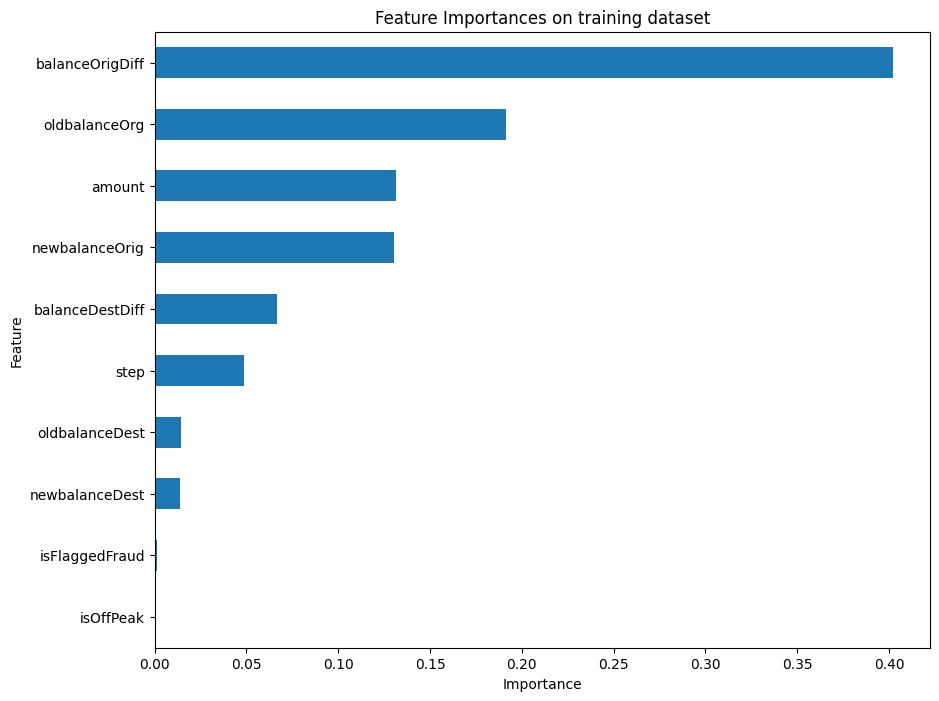

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use actual feature names from x_train_smote
all_feature_names = x_train_smote.columns


#get feature importances
mdi_importances = pd.Series(rf_clf.feature_importances_, index=all_feature_names).sort_values(ascending=True)

#plot feature importances
mdi_importances.plot(kind='barh', figsize=(10,8))
plt.title('Feature Importances on training dataset')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

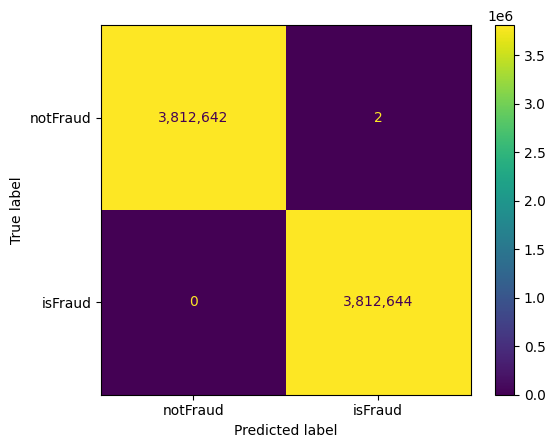

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# evaluate model with Confusion Matrix on training data
cm = confusion_matrix(y_train_smote, y_train_pred, labels = y_train.unique())
class_labels = ['notFraud', 'isFraud']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(values_format = ',d')  # set values_format to 'd' to display as whole numbers
plt.show()

Fitting 3 folds for each of 2 candidates, totalling 6 fits


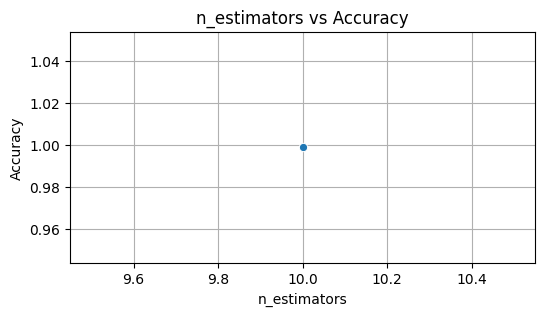

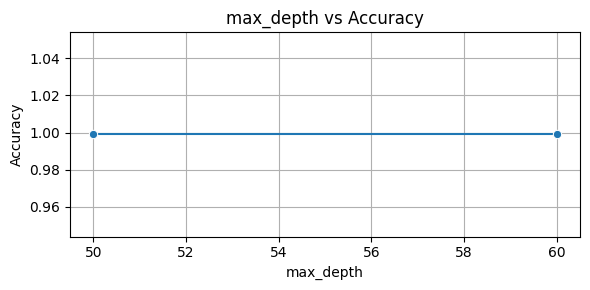

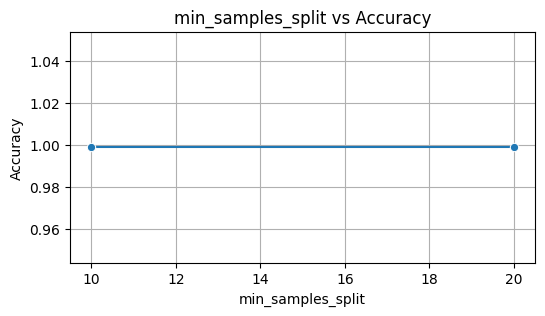

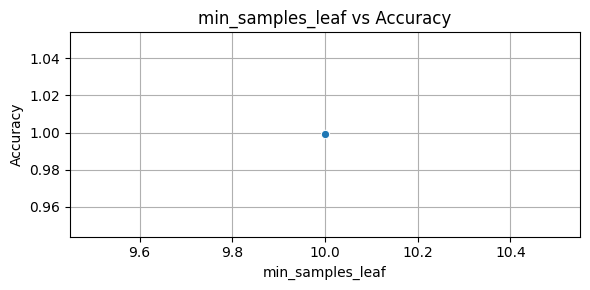

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [50, 60, 30],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [10, 20, 30]
}

#This will perform randomized search cross-validation using the built-in function.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced') #controls the randomness 5
random_search= RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid, cv=3, scoring='accuracy', n_iter=2, random_state=42, n_jobs=-1, verbose=2)#perform randomized search cross-validation using the built-in function.
random_search.fit(x_train_smote, y_train_smote) #trains training dataset


# Extract results from the grid search.
results = pd.DataFrame(random_search.cv_results_)

#This will make the max_depth & n_estimators plots:
plt.figure(figsize=(6, 3))  # size graph
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')  # plot the results for n_estimators
plt.title('n_estimators vs Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)

plt.figure(figsize=(6, 3))  # size graph
sns.lineplot(data=results, x='param_max_depth', y='mean_test_score', marker='o')  # plot the results for max_depth
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()  # adjust subplot parameters to create an organized display
plt.show()  # display the plots overall

#This will make the min_samples_split & min_samples_leaf plots:

plt.figure(figsize=(6, 3))  # size graph
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_score', marker='o')  # plot the results for min_samples_split
plt.title('min_samples_split vs Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.grid(True)

plt.figure(figsize=(6, 3))  # size graph
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_score', marker='o')  # plot the results for min_samples_leaf
plt.title('min_samples_leaf vs Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()  # adjust subplot parameters to create an organized display
plt.show()  # display the plots overall

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

#This will combine training and validation Data using pandas concatenation and store into two separate variables combined:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_train_val_smote, y_train_val_smote = smote.fit_resample(X_train_val, y_train_val)
x_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

#trains optimized model.
clf_optimized = RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=10, min_samples_leaf=10,random_state=42, n_jobs=-1, class_weight='balanced') #Insert optimal hyperparameters.
clf_optimized.fit(x_train_val_smote, y_train_val_smote)  # trains the combined data
y_test_pred = clf_optimized.predict(x_test_smote) #This will test the Model on test dataset using the optimal hyperparameters by using predict bulit-in function.
test_report = classification_report(y_test_smote, y_test_pred, zero_division=0, target_names=['notFraud', 'isFraud'])
print("Testing Results:\n", test_report)

Testing Results:
               precision    recall  f1-score   support

    notFraud       0.98      1.00      0.99   1270882
     isFraud       1.00      0.98      0.99   1270882

    accuracy                           0.99   2541764
   macro avg       0.99      0.99      0.99   2541764
weighted avg       0.99      0.99      0.99   2541764



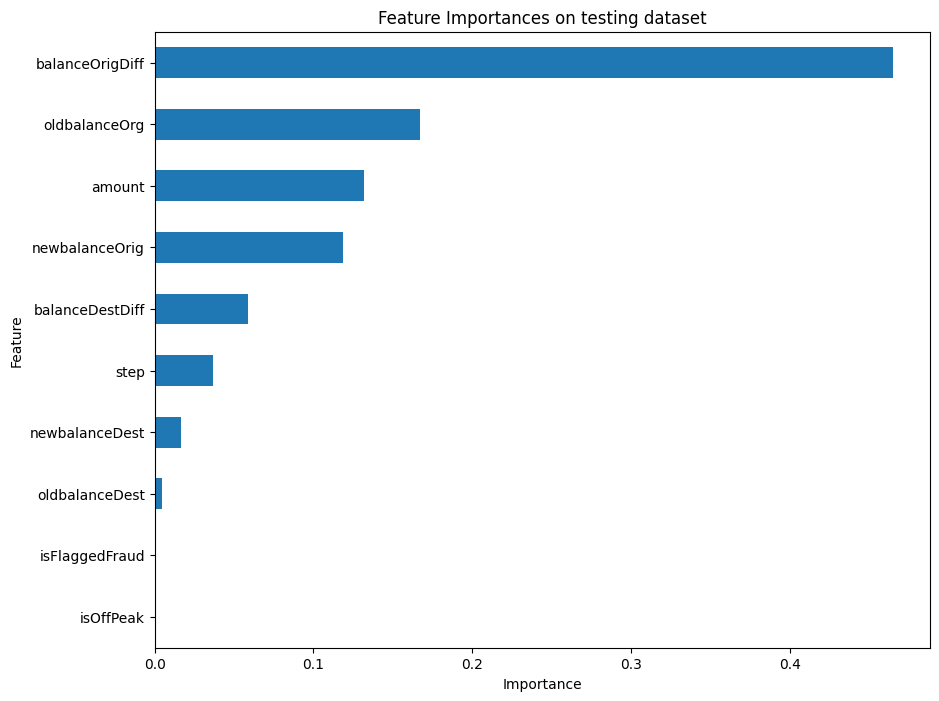

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use actual feature names from X_train_val
all_feature_names = x_train_val_smote.columns


#get feature importances
mdi_importances = pd.Series(clf_optimized.feature_importances_, index=all_feature_names).sort_values(ascending=True)

#plot feature importances
mdi_importances.plot(kind='barh', figsize=(10,8))
plt.title('Feature Importances on testing dataset')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

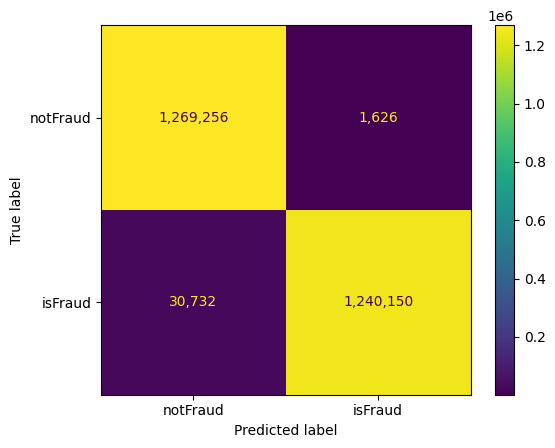

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# evaluate model with Confusion Matrix on testing data
cm = confusion_matrix(y_test_smote, y_test_pred, labels = clf_optimized.classes_)
class_labels = ['notFraud', 'isFraud']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(values_format = ',d')  # set values_format to 'd' to display as whole numbers
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert y_test_pred into DataFrame for scatterplot
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['Prediction'])
# Combine with the original test data for more meaningful visualization
X_test_df = pd.DataFrame(x_test_smote)

# Verify shapes
print("Shape of y_test_pred_df:", y_test_pred_df.shape)
print("Shape of X_test_df:", X_test_df.shape)

#combine for scatter plot
scatter_data = pd.concat([X_test_df.reset_index(drop=True), y_test_pred_df], axis=1)
# Convert numerical predictions to text labels
scatter_data['Prediction'] = scatter_data['Prediction'].map({0: 'notFraud', 1: 'isFraud'})

# Verify data preparation
print("Shape of scatter_data:", scatter_data.shape)
print("Columns in scatter_data:\n", scatter_data.columns)

Shape of y_test_pred_df: (2541764, 1)
Shape of X_test_df: (2541764, 10)
Shape of scatter_data: (2541764, 11)
Columns in scatter_data:
 Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'balanceOrigDiff',
       'balanceDestDiff', 'isOffPeak', 'Prediction'],
      dtype='object')


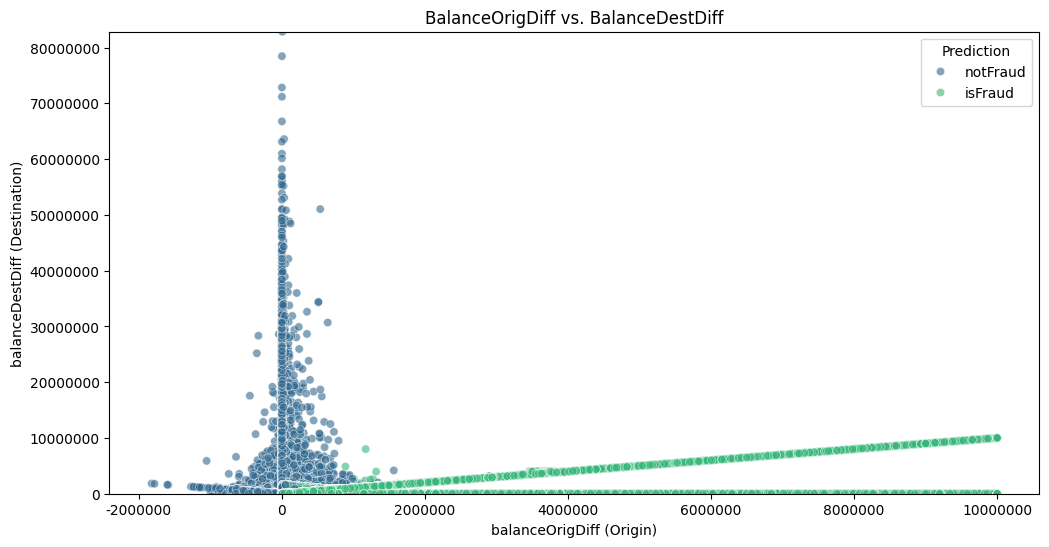

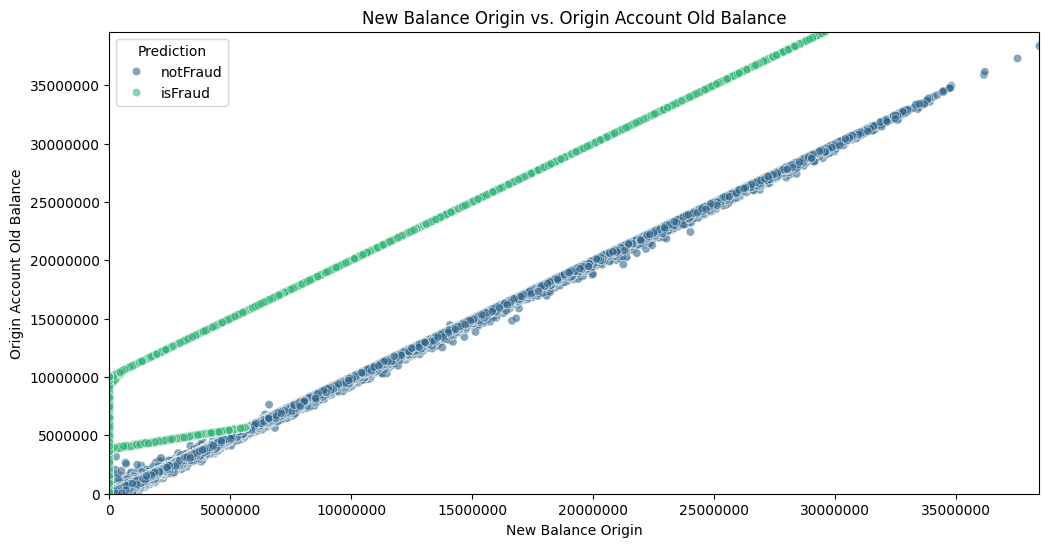

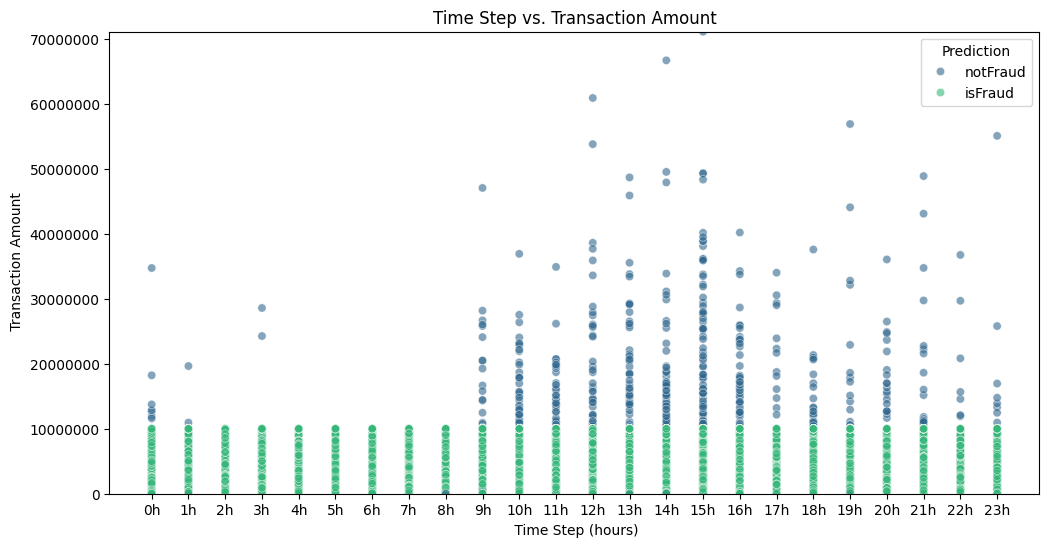

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler

# Example scatterplot of 'balanceOrigDiff' vs 'balanceDestDiff'
# balanceOrigDiff = This will determine the difference in the origin account's balance pre and post transaction.
# balanceDestDiff = This will determine the modification in the destination account's balance.
# Fraudulent transactions will spend all the money in the original account and result in massive inconsistent changes in destination account meaning balanceDestDiff would not align correctly with amount.

# Convert 'balanceDestDiff' to its absolute value
scatter_data['balanceDestDiff'] = scatter_data['balanceDestDiff'].abs()

plt.figure(figsize=(12,6))
sns.scatterplot(data=scatter_data, x="balanceOrigDiff", y="balanceDestDiff", hue="Prediction", palette="viridis", alpha=0.6)

plt.title('BalanceOrigDiff vs. BalanceDestDiff')
plt.xlabel('balanceOrigDiff (Origin)')
plt.ylabel('balanceDestDiff (Destination)')
# Remove scientific notation from the x-axis and y-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0f}'))
# Set limits to better reflect dataset's values
#plt.xlim(scatter_data['balanceOrigDiff'].min(), scatter_data['balanceOrigDiff'].max())
plt.ylim(scatter_data['balanceDestDiff'].min(), scatter_data['balanceDestDiff'].max())
# Add legend
plt.legend(title='Prediction', loc='best')
plt.show()

# Example scatterplot of 'oldbalanceOrg' vs 'newbalanceOrig'
plt.figure(figsize=(12,6))
sns.scatterplot(data=scatter_data, x="newbalanceOrig", y="oldbalanceOrg", hue="Prediction", palette="viridis", alpha=0.6)

plt.title('New Balance Origin vs. Origin Account Old Balance')
plt.xlabel('New Balance Origin')
plt.ylabel('Origin Account Old Balance')
# Remove scientific notation from the x-axis and y-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0f}'))


# Set limits to better reflect dataset's values
plt.xlim(scatter_data['newbalanceOrig'].min(), scatter_data['newbalanceOrig'].max())
plt.ylim(scatter_data['oldbalanceOrg'].min(), scatter_data['oldbalanceOrg'].max())
# Add legend
plt.legend(title='Prediction', loc='best')
plt.show()


# Example scatterplot of 'step' vs 'amount'
# Fraud may occur during specific time periods like off-peak hours when there is less activity.
# high transaction amounts at suspicious time steps could mean fraud.

# Filter data to include all 24 hours
scatter_data['step'] = scatter_data['step'] % 24 # Create a new column for hours in the 24-hour format

plt.figure(figsize=(12,6))
sns.scatterplot(data=scatter_data, x="step", y="amount", hue="Prediction", palette="viridis", alpha=0.6)

# Update x-axis to show all 24 hours
plt.xticks(range(0, 24), labels=[f'{i}h' for i in range(24)])

plt.title('Time Step vs. Transaction Amount')
plt.xlabel(' Time Step (hours)')
plt.ylabel(' Transaction Amount')
# Remove scientific notation from the x-axis and y-axis
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0f}'))
# Set limits to better reflect dataset's values
#plt.xlim(scatter_data['step'].min(), scatter_data['step'].max())
plt.ylim(scatter_data['amount'].min(), scatter_data['amount'].max())
# Add legend
plt.legend(title='Prediction', loc='best')
plt.show()
